<a href="https://colab.research.google.com/github/LeonardoHoltz/MachineLearningDiabetesPredict/blob/main/Trabalho_de_Aprendizado_de_M%C3%A1quina_Classifica%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Descrição

Nosso trabalho tem como objetivo desenvolver um modelo baseado em aprendizado de máquina para prever o diagnóstico de diabetes em mulheres a partir de um conjunto de informações médicas sobre pacientes. Para tanto, utilizamos o conjunto de dados do National Institute of Diabetes and Digestive and Kidney Diseases que contém medições de diagnóstico e informações de mulheres, com mais de 21 anos, pertencente aos pimas, um povo nativo americano. Este conjunto foi usado em um estudo sobre ADAP Learning de Smith et al. (1988) e está disponível em https://www.kaggle.com/datasets/whenamancodes/predict-diabities para download.

# Atributos
Há um total de 8 atributos no conjunto de dados, todos referentes a informações médicas:

- Pregnancies: Quantas vezes que a paciente engravidou;

- Glucose: Glicemia medida por meio de um teste de curva glicemica de 2 horas (provavelmente em mg/dL).

- BloodPressure: Pressão arterial diastólica (mmHg);

- SkinThickness: Espessura da pele medida por meio de uma dobra cutânea do triceps(mm);

- Insulin: Nível de insulina no corpo após 2 horas de aplicação de soro (μU/ml);

- BMI: Índice de massa corporal (kg/m²);

- DiabetesPedigreeFunction: Função criada pelos autores Smith et al. (1988) que fornece uma medida da influência genética para o risco de diabetes em um indivíduo. Quanto maior o número, maior a chance da pessoa possivelmente desenvolver diabetes.

- Age: Idade

Vale lembrar que todos os atributos presentes são númericos, o que pode impactar significantemente nos algoritmos usados no modelo final.

# Checklist do Trabalho
- [X] Escolher dataset
- [X] Pré-processar dados
- [X] Escolher 3 algoritmos de aprendizado de máquina
- [X] Implementação própria da estratégia k-fold cross validation estratificado
- [X] Implementar função própria para gerar uma matriz de confusão
- [X] Quantificar métricas: precisão, acurácia, recall e F1-measure (funções próprias)
- [X] Aplicar estratégia de k-fold CV, matriz de confusão e métricas ao problema de classificação selecionado
- [X] Reportar:
    - [X] Desempenho médio
    - [X] Desvio padrão
    - [X] Discutir resultados de forma comparativa entre os algoritmos usados
- [X] Usar boxplot para avaliar a distribuição do desempenho


## Algoritmos escolhidos
1. Florestas aleatórias
2. Regressão logística
3. K Vizinhos mais próximos


In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold # hyperparam optim.
from sklearn.metrics import accuracy_score
from scipy import stats
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

sns.set()

# Instâncias

O dataset possui um total de 768 instâncias, sem duplicatas, considerando possíveis inconsistências de classes (mesmo X e diferentes y), e com todos os atributos preenchidos.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/LeonardoHoltz/MachineLearningDiabetesPredict/main/diabetes.csv')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [ ]:
## Duplicates verification with y
df.drop_duplicates(keep=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
## Duplicates verification without y
X = df.drop(['Outcome'], axis=1)
X.drop_duplicates(keep=False)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 48.1 KB


# Distribuição de valores por atributo

## Atributo Alvo

A partir da distribuição, podemos notar que o dataset é levemente desbalanceado. A classe negativa é a predominante no conjunto de dados, presente em 65.1% das instâncias. A partir disso, devemos tomar cuidado em estratificar os dados na hora de construir nosso modelo e usar métricas de desempenho efetivas para dados desbalanceados. 

In [ ]:
def plot_target_dist_percentual(df_vc, total):
  """
  Defines a plot figure with a histogram, showing how many rows exists for each class
  and the percentual distribution of each class in the dataset.
  """
  sns.set_context("notebook", font_scale=2)
  sns.set_palette("deep")
  plt.figure(figsize=(8, 9))
  ax = sns.barplot(x=df_vc.index, y=df_vc.values)
  for p in ax.patches:
      percentage = '{:.1f}%'.format(100 * p.get_height()/total)
      x = p.get_x() + (p.get_width() / 2)
      y = p.get_height()
      ax.annotate(percentage, (x, y),ha='center')
  plt.xlabel("Classes")
  plt.ylabel("Rows")
  plt.suptitle("Target column distribution")
  plt.show()

Dataset has 268 instances of the positive class and has 500 instances of the negative class.


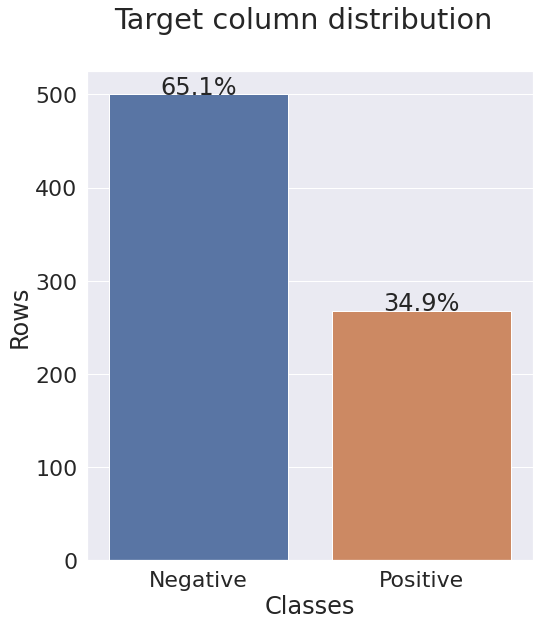

In [ ]:
## Target column distribution

# First, let's copy the dataframe, renaming the target values to 'Positive' and 'Negative' to a better data visualization
df_vis = df.copy(deep=True)
df_vis['Outcome'].replace([0, 1], ['Negative', 'Positive'], inplace=True)

df_vc = df_vis['Outcome'].value_counts()
negative_instances = df_vc[0]
positive_instances = df_vc[1]
total = negative_instances + positive_instances

print(f"Dataset has {positive_instances} instances of the positive class and has {negative_instances} instances of the negative class.")

plot_target_dist_percentual(df_vc, total)

## Distribuição dos demais atributos

Para esta distribuição utilizamos, para cada atributo, dois bloxplots: Um para a classe positiva e outro para a classe negativa.

Ao analisar os atributos do conjunto de dados e suas variações entre as classes negativa e positiva, podemos inferir atributos que podem ser decisivos na tomada de decisão dos nossos algoritmos, baseado na diferença entre suas distribuições e variações.

A maioria dos atributos possuem valores maiores na classe positiva. Em especial, os atributos *Glucose* e *BloodPressure* são os que mais se diferenciam entre as classes, o que faz sentido, dados os sintomas encontrados em pacientes com Diabetes.

### Outliers

É possível notar também uma quantidade considerável de *outliers* nos dados. É importante que o nosso modelo possa beneficiar-se dos atributos onde existe uma maior diferença na distribuição dos dados, mas que principalmente seja genérico e não se baseie nos *outliers* para classificar novos dados.

### Valores inválidos

O boxplot deixa claro a quantidade de valores inválidos para alguns atributos, que são caracterizados pelo número 0. Sabemos que valores 0 são inválidos porque o domínio do nosso problema não trabalha com valores 0 para *Glucose*, *BloodPressure*, *SkinThickness*, *Insulin* e *BMI*.

Decidimos usar, em uma de nossas estratégias para testar o modelo, o dataset sem valores inválidos. Em outra estratégia, decidimos imputar outros valores no lugar dos inválidos. Esperamos que as duas estratégias tenham performances melhores do que simplesmente usar os dados de forma crua.


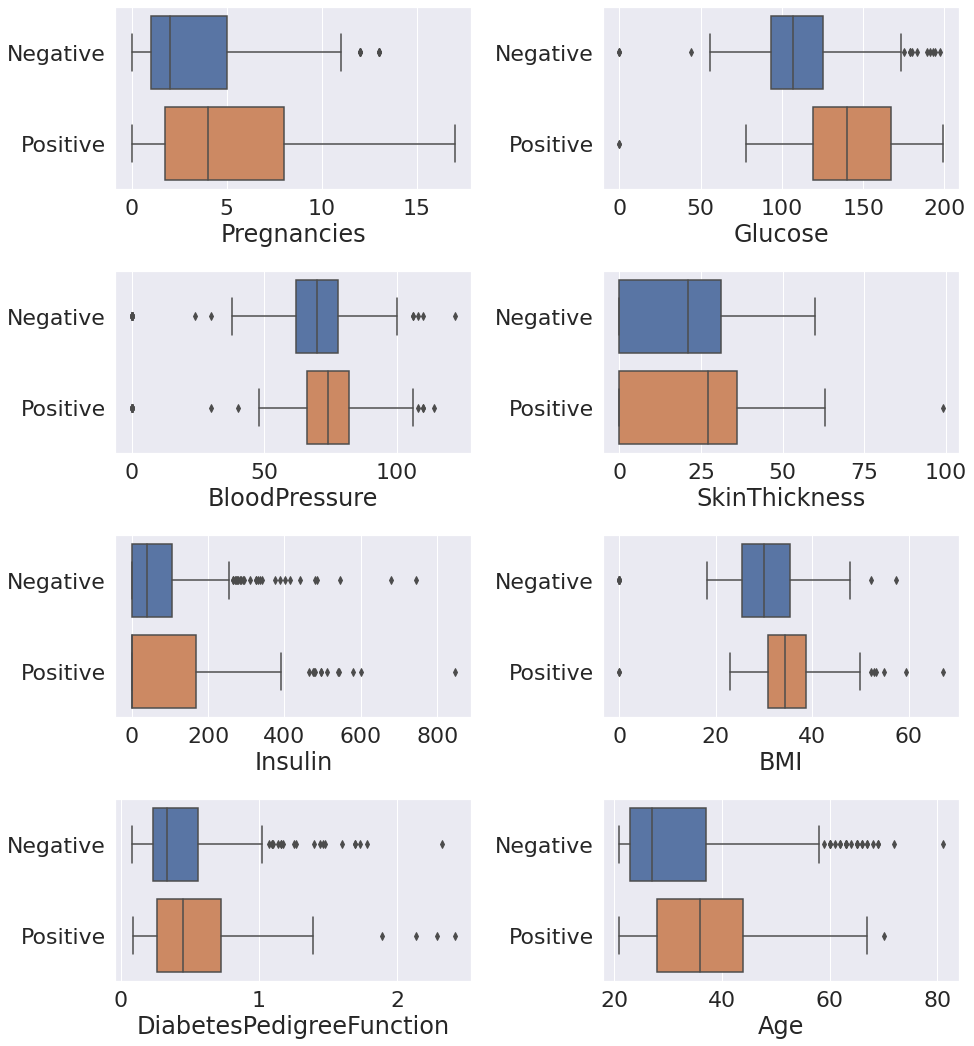

In [ ]:
## Check distribution in each column, except 'Outcome'
def columns_box_plot(df, columns, label):
    plt.figure(figsize=(14, 15))
    sns.set_context("notebook", font_scale=2)
    sns.set_palette("deep")
    for idx, var in enumerate(columns):
        plt.subplot(4, 2, idx+1)
        g = sns.boxplot(data=df, x=var, y=label, order=['Negative', 'Positive'])
        plt.ylabel('')
    plt.tight_layout(pad=1)

columns_box_plot(df_vis, df_vis.columns[:8], 'Outcome')

# Análise dos dados

Somente para as análises de correlações, iremos desconsiderar os dados inválidos do nosso dataset por enquanto. O ruído nos dados pode ser prejudicial para a identificação de relações lineares e para as tomadas de decisões resultantes da análise.

In [ ]:
df_all_valid = df.loc[(df['BMI'] != 0) & (df['Insulin'] != 0) & (df['BloodPressure'] != 0) & (df['Glucose'] != 0) & (df['SkinThickness'] != 0)]

## Pair plot

O pair plot nos permite identificar relações entre os atributos. Quanto mais as instâncias (representadas pelos pontos) estão espalhadas, menos relação há entre os atributos. De forma contrária, quanto mais as instâncias estão juntas em uma linha, mais linearmente relacionados eles estão.

### Correlação entre BMI e SkinThickness

A relação mais evidente para nós foi a entre *BMI* e *SkinThickness*. Essa relação faz sentido ao pensarmos que valores de índice de massa corporal altos indicam obesidade, o que indica altas taxas de gordura no corpo e, consequentemente, uma alta medida de dobra cutânea.

Acreditamos que os dois atributos sejam redundantes entre si para a criação de um modelo. Ambos são usados como medidas para detectar obesidade na área da saúde e acreditamos que a medida de dobra cutânea seja supérflua.

Decidimos avaliar modelos com e sem o atributo *SkinThickness* e verificarmos a performance.

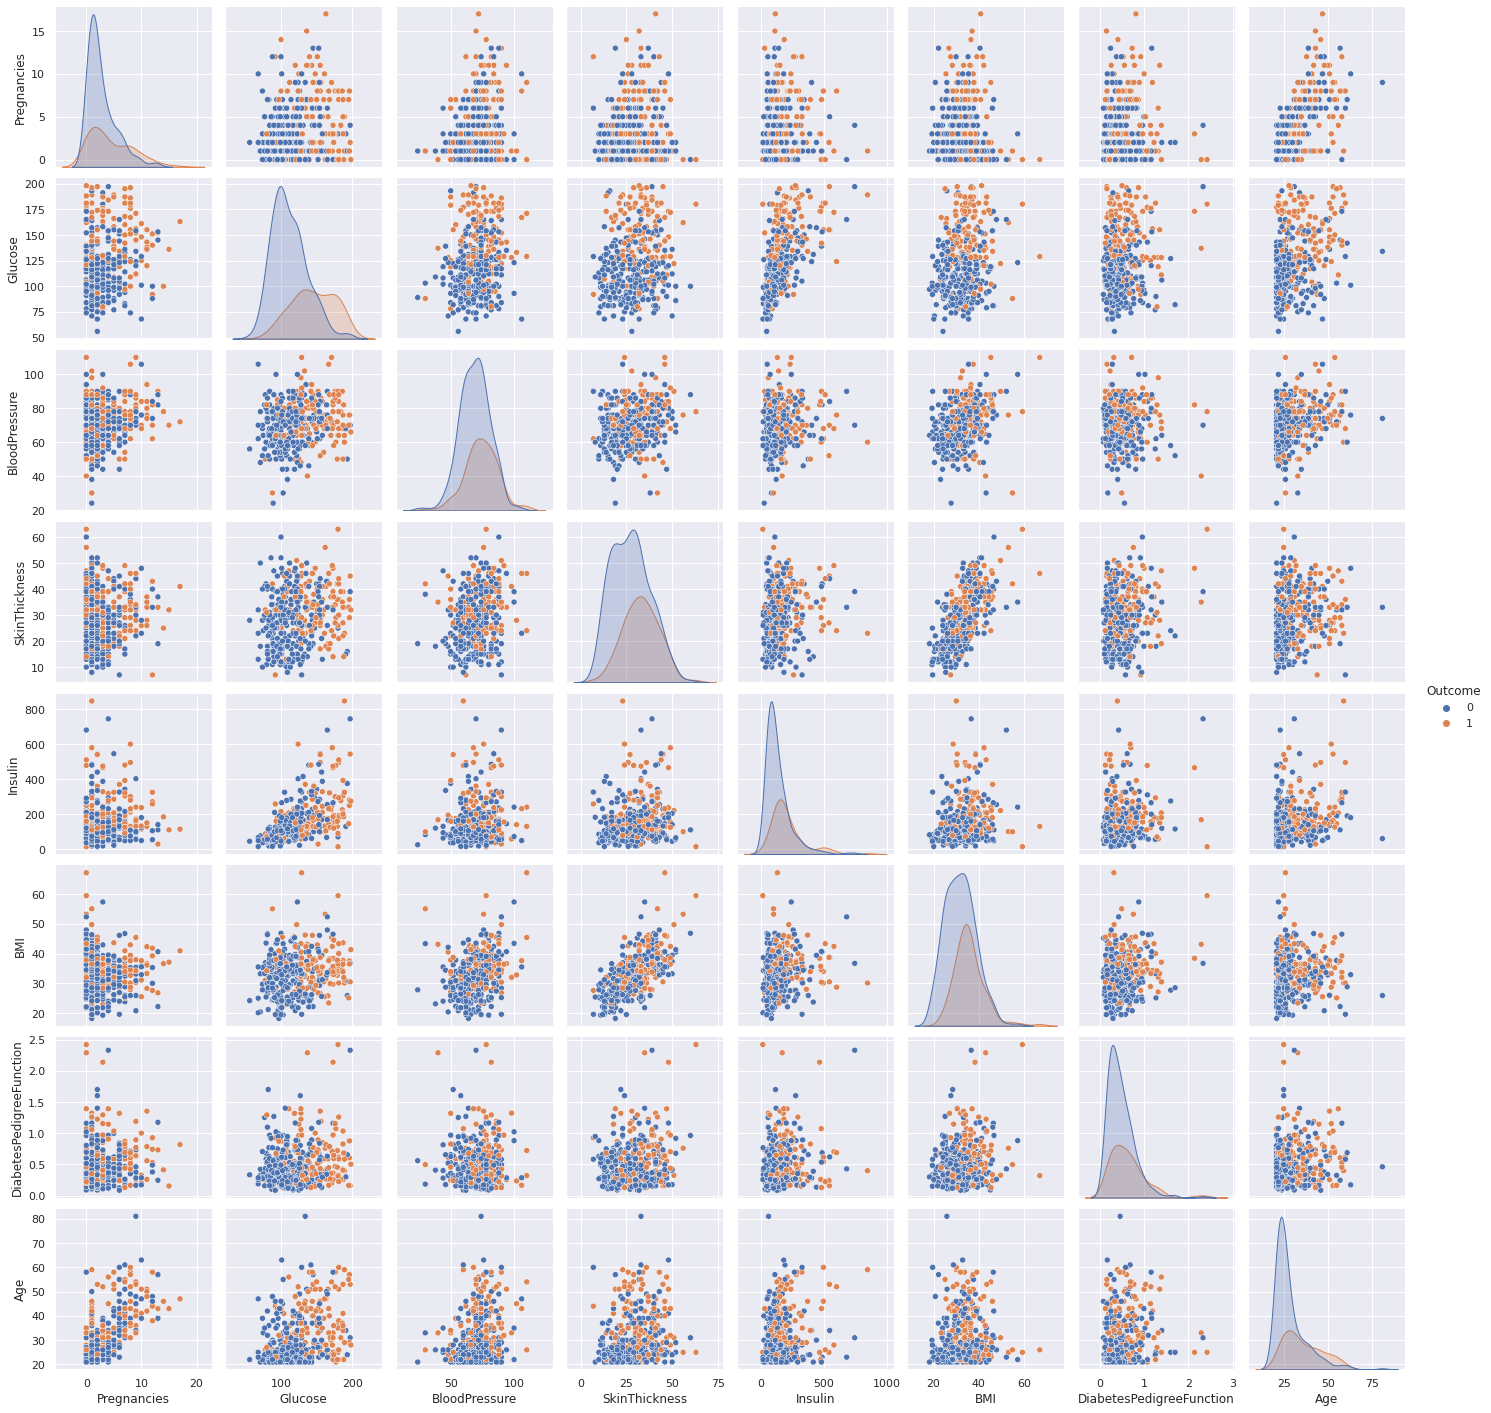

In [ ]:
sns.set_context("notebook", font_scale=1)
sns.pairplot(df_all_valid, hue='Outcome')

## Matrix de correlação

Utilizamos uma matriz de correlação para complementar a análise anterior. Em específico, utilizamos o método de Pearson, onde é possível identificar correlações positivas e negativas. A partir disso, inferimos as informações abaixo a partir das correlações entre os atributos.

- *Pregnancies* e *Age* (0.68) possuem uma correlação forte, o que é natural, já que um número elevado de gravidezes é mais comum de se ver em mulheres mais velhas. Isso não acaba contribuindo para identificarmos um padrão para o nosso problema, mas, caso viessemos a realizar uma análise de componente principal (PCA) futuramente, estes dois atributos poderiam ser fortes concorrentes a formarem um componente.

- *BMI* e *SkinThickness* (0.66) tem sua correlação mostrada novamente aqui, dessa vez de forma mais clara.

- *Glucose* e *Outcome* (0.52) também possuem uma forte correlação, o que novamente faz sentido, pois pacientes com altas taxas de glicose no sangue tendem a ter diabetes. Isso pode indicar que o atributo *glucose* tenha um alto score e seja um dos atributos que os algoritmos de classificação mais vão se basear para tomar suas decisões, especialmente as árvores de decisão nas nossas florestas aleatórias.

- *Glucose* e *Insulin* (0.58) também estão correlacionados aqui. Entretanto, essa é uma correlação que deveria ser negativa, já que a insulina e glicose funcionam de maneira inversa no corpo humano. No domínio do nosso problema, isso poderia indicar resistencia do corpo à insulina, o que potencialmente poderia acabar levando uma paciente a ter diabetes futuramente.

<Axes: >

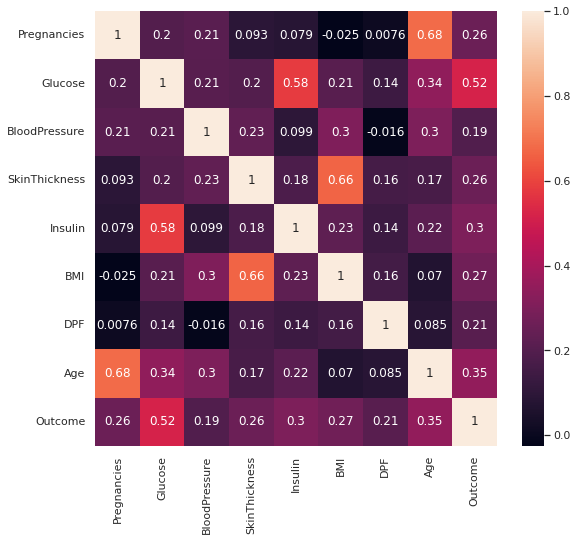

In [ ]:
df_all_valid.rename(columns={'DiabetesPedigreeFunction': 'DPF'}, inplace=True)
corr_matrix = df_all_valid.corr(method='pearson')
plt.figure(figsize=(9, 8))
sns.heatmap(corr_matrix, annot = True)

## Analise de Outliers

Como foi visto na distribuição dos atributos, os box plots mostraram muitos outliers em sua distribuição. Para esta análise, decidimos quantificar eles  e verificar se a quantidade é pequena o suficiente para apenas os invalidarmos e imputarmos novos valores. Utilizamos o algoritmo IQR e fizemos duas análises, uma para cada multiplicadores de IQR, um valor 1.5 e um valor 3.0 para outliers extremos.

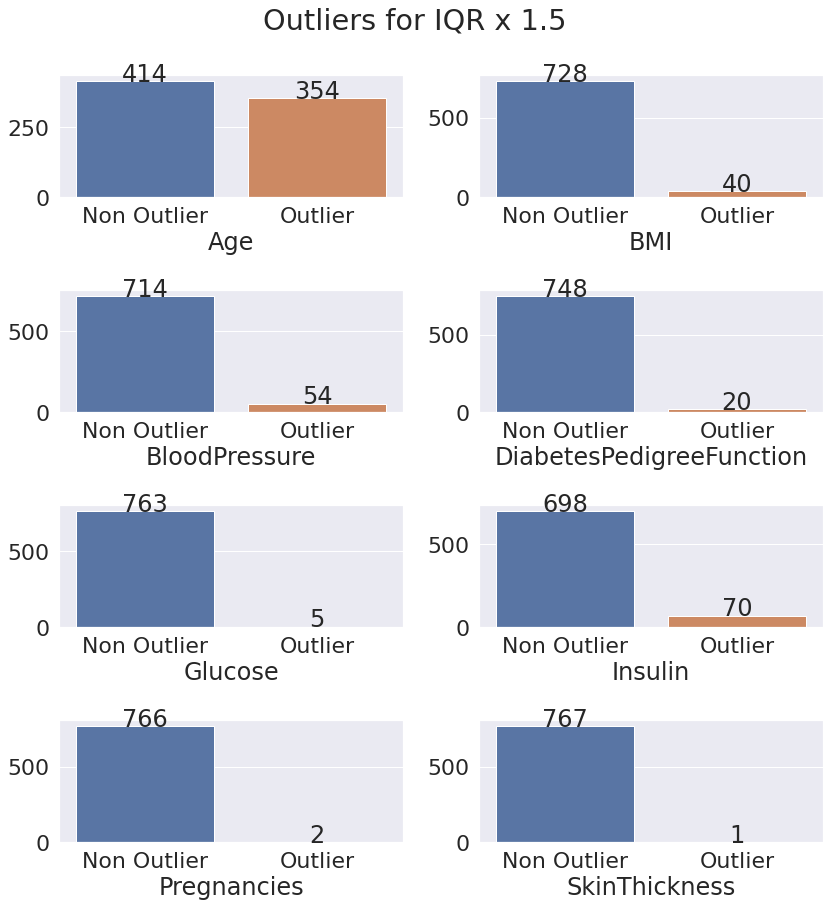

In [ ]:
def plot_outliers(outliers, columns, iqr_scale):
  outliers.replace([False, True], ['Non Outlier', 'Outlier'], inplace=True)
  sns.set_context("notebook", font_scale=2)
  sns.set_palette("deep")
  plt.figure(figsize=(12, 13))
  plt.suptitle(f'Outliers for IQR x {iqr_scale}')
  for idx, var in enumerate(columns):
        total = len(outliers)
        outliers_vc = outliers[var].value_counts()
        plt.subplot(4, 2, idx+1)
        ax = sns.barplot(x=outliers_vc.index, y=outliers_vc.values)
        plt.ylabel('')
        plt.xlabel(var)
        for p in ax.patches:
            height = int(p.get_height())
            x = p.get_x() + (p.get_width() / 2)
            y = p.get_height()
            ax.annotate(height, (x, y),ha='center')
  plt.tight_layout(pad=1)
  

def outlier_analysis_iqr(df, iqr_scale):
    df_out_analysis = df.copy(deep=True)
    Q1 = df_out_analysis[:8].quantile(0.25)
    Q3 = df_out_analysis[:8].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df_out_analysis.iloc[:, 0:8].lt(Q1 - iqr_scale * IQR) | df_out_analysis.iloc[:, 0:8].gt(Q3 + iqr_scale * IQR) # usual < and > are deprecated
    outliers = outliers.drop("Outcome" , axis=1)
    plot_outliers(outliers, outliers.columns, iqr_scale)

outlier_analysis_iqr(df, iqr_scale=1.5)

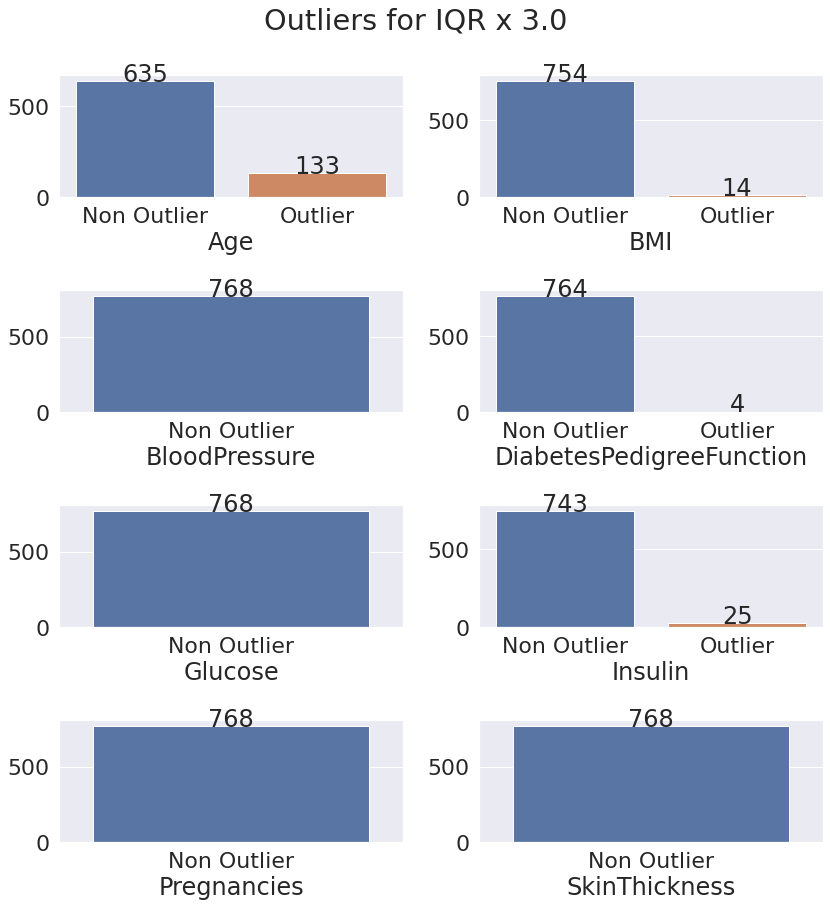

In [ ]:
outlier_analysis_iqr(df, iqr_scale=3.0)

## Detecção de Outliers e KNN Inputer

Como nossos dados possuem Outliers, foi aplicado o metodo IQR para detecção de outliers e para os valores NaN foi aplicado KNNInputer.


In [ ]:
def outliers_remover(xtrain, y_train, extreme, exceptions_col):
  """
  IQR Outlier Remover for Train dataset
  """
  Q1 = xtrain[:8].quantile(0.25)
  Q3 = xtrain[:8].quantile(0.75)
  IQR = Q3-Q1
  if extreme:
    multiplier = 3
  else:
    multiplier = 1.5
  selection = ( xtrain.columns.isin(exceptions_col) | ((xtrain>=(Q1-(multiplier*IQR))) & (xtrain<=(Q3+(multiplier*IQR))))) # Create selection according to IQR
  xtrain  = xtrain.iloc[:, 0:8][selection]
  xtrain = pd.DataFrame(xtrain)

  return xtrain.reset_index(drop=True)

def outliers_remover_test(xtrain, xtest, y_test, extreme, exceptions_col):
  """
  IQR Outlier Remover for test dataset
  """
  Q1 = xtrain[:8].quantile(0.25)
  Q3 = xtrain[:8].quantile(0.75)
  IQR = Q3-Q1
  if extreme:
    multiplier = 3
  else:
    multiplier = 1.5
  selection = ( xtest.columns.isin(exceptions_col) | ((xtest>=(Q1-(multiplier*IQR))) & (xtest<=(Q3+(multiplier*IQR))))) #Create selection according to IQR
  xtest  = xtest.iloc[:, 0:8][selection]
  xtest  = pd.DataFrame(xtest)

  return xtest.reset_index(drop=True)

def preprocessing_missing_value(x):
    x[['Glucose','BloodPressure','Insulin ','SkinThickness','BMI']] = x[['Glucose','BloodPressure','Insulin','SkinThickness','BMI']].replace(0,np.NaN)
    return x


def knn_inputer(x_train, y_train, x_test, y_test, n_neighbors):
    """ 
    KNN Inputer for Train and Test Dataset
    """
    # Values for KnnInputer for Test and Train dataset 
    dftrain = x_train
    dftrain = x_train.join(y_train)
    dftrain_columns = df.columns  #This is for Numpy to Pandas Dataframe Transformation

    dftest = x_test
    dftest = x_test.join(y_test)
    dftest_columns = dftest.columns #This is for Numpy to Pandas Dataframe Transformation

    #Training KnnInputer

    imputer = KNNImputer(n_neighbors=n_neighbors)
    imputer = imputer.fit(dftrain.to_numpy())

    #Transform Training data
    dftrain = imputer.transform(dftrain.to_numpy())
    dftrain = pd.DataFrame(dftrain)

    #Transform Test Data
    dftest = imputer.transform(dftest.to_numpy())
    dftest = pd.DataFrame(dftest)
    
    collumny = len(dftrain.columns)-1
    return dftrain.loc[:, dftrain.columns != collumny] ,  dftest.loc[:, dftest.columns != collumny]

## Normalização dos dados

Como nossos dados possuem atributos que variam muito de escala, devemos normalizar os dados, pois alguns dos algoritmos que utilizaremos são sensíveis a mudanças na escala (regressão logística e KNN).

Aqui, apenas definimos as funções que usamos para normalizar os dados. Elas seram usadas posteriormente.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def normalize_train_and_test(x_train, x_test):
    scaler = MinMaxScaler()
    scaler.fit(x_train)
    x_train[x_train.columns] = scaler.transform(x_train)
    x_test[x_test.columns] = scaler.transform(x_test)
    return x_train, x_test

# Seed

Para este trabalho, usaremos a mesma seed para todos os random states. Definimos ela como 2023.

In [ ]:
global_seed = 2023

# Cross Validation: Definição dos folds e split dos dados

In [ ]:
class OurCrossValidation:
    def __init__(self, n_splits , shuffle=True, random_state=global_seed) -> None:
        self.k = n_splits
        self.shuffle = shuffle
        self.seed = random_state
        
        np.random.seed(self.seed)
    
    def get_X_y(self, df, target_name) -> tuple:
        """
        separates the dataframe in two groups, one with only the target and one without the target
        """
        self.df = df
        self.target_name = target_name
        X = df.drop([target_name], axis=1)
        y = df[target_name].values
        return (X, y)
    
    def separate_dataframe_by_target_class(self) -> None:
        """
        Defines a dict that separates the instances of the original dataframe by its class,
        generating multiple dataframes with a unique class.
        
        It will be useful to sample the instances by using the stratified method
        """
        self.classes_df = {}
        by_class = self.df.groupby(self.target_name)

        for group, data in by_class:
            self.classes_df[group] = data

    def generate_folds_sizes(self, y) -> None:
        """
        Generates a list of lists, indicating the folds sizes. The elements of the internal lists indicates the
        number of instances of each class that must be inside the fold.
        """

        self.unique_classes, self.class_counts = np.unique(y, return_counts=True)

        # Creates the data structure of list of lists
        l = []
        for class_count in self.class_counts:
            l.append(list(0 for i in range (self.k)))
        
        # We use list of lists instead of list of tuples (the usual output of a zip)
        # because we want to modify the internal structures
        self.fold_size_proportions = [list(a) for a in zip(*l)]

        # We increment the sizes, one by one, not leaving the folds empty.
        # This part sounds naive compared to other methods to fill the sizes to the above structure,
        # but it works well with big values of k, specially when using the leave one out strategy.
        fold_count = 0
        for cls, class_count in enumerate(self.class_counts):
            for i in range(class_count):
                self.fold_size_proportions[fold_count][cls] += 1
                if fold_count + 1 < self.k:
                    fold_count += 1
                else:
                    fold_count = 0
    
    def split(self, X, y):
        """
        Generator function
        """
        for fold_size in self.fold_size_proportions: # yield iterator

            samplings = []

            # Samples for each class and remove the sampled rows from the dataframe
            for uniq_cls, size_per_class in zip(self.unique_classes, fold_size):
                # TODO: If shuffle is set to false, we should use another function than the sample one
                fold_content_per_class = self.classes_df[uniq_cls].sample(n=size_per_class, replace=False, random_state=self.seed)
                self.classes_df[uniq_cls].drop(index=fold_content_per_class.index.values.tolist(), inplace=True)
                samplings.append(fold_content_per_class)

            # Merges the sample for each class
            sample = pd.concat(samplings)
            sample_index = sample.index.values.tolist()

            # generates a list of binary values, indicating for each
            # row of X if it is in the sample or not
            is_in_sample  = X.index.isin(sample_index)
            # Generator return
            yield  X[is_in_sample], y[is_in_sample], X[~is_in_sample], y[~is_in_sample] # x_test, y_test, x_train, y_train


# Matrix de Confusão

In [ ]:
## Confusion Matrix: Since our problem uses a binary class,
## we are only implementing the binary confusion matrix
class BinaryConfusionMatrix:
    def __init__(self, y_pred, y_test):
        self.TP = 0
        self.FP = 0
        self.FN = 0
        self.TN = 0
        for prediction, ground_truth in zip(y_pred, y_test):
            if prediction == 1:
                if(prediction == ground_truth):
                    self.TP += 1
                else:
                    self.FP += 1
            else:
                if(prediction == ground_truth):
                    self.TN += 1
                else:
                    self.FN += 1
        self.confusion_matrix = [[self.TP, self.FP], [self.FN, self.TN]]

# Cross Validation Score and Inner Grid Search

Dentro da validação cruzada, adicionamos a opção de otimizar os hiperparâmetros por meio de uma validação cruzada interna. Usamos a métrica de sensibilidade (recall) como métrica a ser otimizada, já que se trata de um dataset da área médica, onde queremos diminuir a taxa de falsos negativos. Caso fossemos usar o modelo para diagnosticar pacientes reais, não queremos diagnosticar pacientes com um resultado negativo, quando na verdade elas possuem diabetes.

Optamos por deixar fixo a quantidade de folds da validação interna como 5.

In [ ]:
from sklearn.model_selection import GridSearchCV

## Score class
class OurScore:
    def __init__(self):

        self.acc = 1.0
        self.err = 0.0
        self.prec = 1.0
        self.rec = 1.0
        self.f1 = 1.0
        

    def set_score_by_predictions(self, y_pred, y_test):
        cm = BinaryConfusionMatrix(y_pred, y_test)
        self.acc = self.set_accuracy(cm)
        self.err = self.acc - 1.0
        self.prec = self.set_precision(cm)
        self.rec = self.set_recall(cm)
        self.f1 = self.set_f1()

    def set_f1(self):
        if((self.prec + self.rec)==0):
          return 1
        return (2 * self.prec * self.rec) / (self.prec + self.rec)

    def set_accuracy(self, cm):
        return (cm.TP + cm.TN) / (cm.TP + cm.FP + cm.FN + cm.TN)

    def set_precision(self, cm):
        if((cm.TP + cm.FP)==0):
          return 1
        return cm.TP / (cm.TP + cm.FP)

    def set_recall(self, cm):
        return cm.TP / (cm.TP + cm.FN)


class CrossValidationFinalScore:
    def __init__(self, score_list):
        self.score_list = score_list
        self.acc_mean = np.mean([s.acc for s in score_list])
        self.prec_mean = np.mean([s.prec for s in score_list])
        self.rec_mean = np.mean([s.rec for s in score_list])
        self.f1_mean = np.mean([s.f1 for s in score_list])
        self.err_mean = self.acc_mean - 1.0

        self.acc_std = np.std([s.acc for s in score_list])
        self.prec_std = np.std([s.prec for s in score_list])
        self.rec_std = np.std([s.rec for s in score_list])
        self.f1_std = np.std([s.f1 for s in score_list])

    def show_score(self):
        print("======= SCORE =======")
        print(f'Accuracy Mean: {self.acc_mean}')
        print(f'Accuracy Std: {self.acc_std}')
        print(f'Precision Mean: {self.prec_mean}')
        print(f'Precision Std: {self.prec_std}')
        print(f'Recall Mean: {self.rec_mean}')
        print(f'Recall Std: {self.rec_std}')
        print(f'F1 Score Mean: {self.f1_mean}')
        print(f'F1 Score Std: {self.f1_std}')
        print("=====================")

def preprocessing(x_train, x_test, y_train, y_test, knn_imputer_n_neighbors, extreme_outliers, outliers_expection_col):
    x_train  = preprocessing_missing_value(x_train)
    x_test   = preprocessing_missing_value(x_test)

    x_train, x_test = normalize_train_and_test(x_train, x_test)

    y_train = pd.DataFrame(y_train) #Transform into DataFrame because Dataframe has better data manipulation methods
    y_test = pd.DataFrame(y_test)

    x_test   = outliers_remover_test(x_train, x_test, y_test, extreme_outliers, outliers_expection_col)
    x_train = outliers_remover(x_train, y_train, extreme_outliers, outliers_expection_col)

    x_train , x_test = knn_inputer(x_train, y_train, x_test, y_test, knn_imputer_n_neighbors) 

    return x_train, x_test

def our_cross_val_score(estimator, X, y, cv, scoring=['accuracy', 'precision', 'recall', 'f1'],
                        outliers_expection_col = [], extreme_outliers = False, knn_imputer_n_neighbors = 2,
                        inner_grid_search=False, param_grid=None, pre_processing = None):
    """
    Create a array with every fold score and return mean of scoring
    """

    cv.separate_dataframe_by_target_class()
    cv.generate_folds_sizes(y)

    scores = []
    
    for x_test, y_test, x_train, y_train in cv.split(X, y): # cross validation main loop
        if pre_processing:
            if pre_processing == 'normalization':
                x_train, x_test = normalize_train_and_test(x_train, x_test)
            if pre_processing == 'imputer':
                x_train, x_test = preprocessing(x_train, x_test, y_train, y_test, knn_imputer_n_neighbors, extreme_outliers, outliers_expection_col)

        score = OurScore()

        if inner_grid_search and param_grid is not None:
            # We define a inner Cross Validation to optimize the hyper parameters
            clf = GridSearchCV(estimator=estimator, scoring=scoring, param_grid=param_grid, cv=5, refit='f1')
            clf.fit(x_train, y_train)
            print(clf.best_params_)
            y_pred = clf.predict(x_test)
            #y_pred = clf.predict(x_train) # if we want to check how was the training

        else:
            estimator.fit(x_train, y_train)
            y_pred = estimator.predict(x_test)

        score.set_score_by_predictions(y_pred, y_test)
        #score.set_score_by_predictions(y_pred, y_train) # if we want to check how was the training 
        scores.append(score)

    return scores


# Funções de análise de desempenho e plot

In [ ]:
def create_metrics_dataframes(scores_rf, scores_lr, scores_knn):
    dict_acc = { 'Random Forest': [s.acc for s in scores_rf.score_list],
                 'Logistic Reg.': [s.acc for s in scores_lr.score_list],
                 'KNN': [s.acc for s in scores_knn.score_list] }
    df_acc = pd.DataFrame(data=dict_acc)
    dict_prec = { 'Random Forest': [s.prec for s in scores_rf.score_list],
                 'Logistic Reg.': [s.prec for s in scores_lr.score_list],
                 'KNN': [s.prec for s in scores_knn.score_list] }
    df_prec = pd.DataFrame(data=dict_prec)
    dict_rec = { 'Random Forest': [s.rec for s in scores_rf.score_list],
                 'Logistic Reg.': [s.rec for s in scores_lr.score_list],
                 'KNN': [s.rec for s in scores_knn.score_list] }
    df_rec = pd.DataFrame(data=dict_rec)
    dict_f1 = { 'Random Forest': [s.f1 for s in scores_rf.score_list],
                 'Logistic Reg.': [s.f1 for s in scores_lr.score_list],
                 'KNN': [s.f1 for s in scores_knn.score_list] }
    df_f1 = pd.DataFrame(data=dict_f1)

    return df_acc, df_prec, df_rec, df_f1


def plot_results_all_classifiers(scores_rf, scores_lr, scores_knn):
    print("Scores for Random Forests:")
    scores_rf.show_score()
    print("Scores for Logistic Regression:")
    scores_lr.show_score()
    print("Scores for K Nearest Neighbors:")
    scores_knn.show_score()
    
    sns.set_context("notebook", font_scale=2)
    sns.set_palette("deep")
    plt.figure(figsize=(14, 16))

    # Put the metrics in a dataframe to facilitate the plot
    df_acc, df_prec, df_rec, df_f1 = create_metrics_dataframes(scores_rf, scores_lr, scores_knn)

    plt.subplot(2, 2, 1)
    plt.title("Accuracy per classifier")
    b1 = sns.boxplot(data=df_acc)
    b1.tick_params(axis='x', labelsize=15)
    b1.tick_params(axis='y', labelsize=20)

    plt.subplot(2, 2, 2)
    plt.title("Precision per classifier")
    b2 = sns.boxplot(data=df_prec)
    b2.tick_params(axis='x', labelsize=15)
    b2.tick_params(axis='y', labelsize=20)

    plt.subplot(2, 2, 3)
    plt.title("Recall per classifier")
    b3 = sns.boxplot(data=df_rec)
    b3.tick_params(axis='x', labelsize=15)
    b3.tick_params(axis='y', labelsize=20)

    plt.subplot(2, 2, 4)
    plt.title("F1-Score per classifier")
    b4 = sns.boxplot(data=df_f1)
    b4.tick_params(axis='x', labelsize=15)
    b4.tick_params(axis='y', labelsize=20)

    plt.show()

# Preparação dos algoritmos, parâmetros, dados e uso deles na validação cruzada


In [ ]:
def cross_validation_training(df, k, pre_processing_option):
    # Create the classifiers and select the possible hyperparameters for each
    clf_rf = RandomForestClassifier(random_state=global_seed)
    clf_lr = LogisticRegression(random_state=global_seed)
    clf_ab = AdaBoostClassifier(estimator=clf_lr, learning_rate=1)
    clf_knn = KNeighborsClassifier()

    clf_rf_grid =  dict(n_estimators=[i for i in range(3,10,1)],criterion=["gini", "entropy"],max_depth=[i for i in range(3,8,1)])
    clf_lr_grid =  dict(C=[100, 10, 1.0, 0.1, 0.01])
    clf_ab_grid = dict(n_estimators=[10, 30, 50, 100, 150], learning_rate=[0.5, 1, 1.5, 2, 2.5])

    clf_knn_grid = dict(n_neighbors=[i for i in range(1,10,2)])

    cv = OurCrossValidation(n_splits=k, shuffle=True, random_state=global_seed)

    # Get the X and y from the dataframe
    X, y = cv.get_X_y(df, 'Outcome')

    # Execution of the cross validation
    score_rf = our_cross_val_score(estimator=clf_rf, X=X, y=y, cv=cv, outliers_expection_col=["Age"],
                                   extreme_outliers=False, inner_grid_search=True, param_grid=clf_rf_grid,
                                   pre_processing=pre_processing_option)
    score_lr = our_cross_val_score(estimator=clf_lr, X=X, y=y, cv=cv, outliers_expection_col=["Age"],
                                   extreme_outliers=False, inner_grid_search=True, param_grid=clf_lr_grid,
                                   pre_processing=pre_processing_option)
    # ada boost
    #score_lr = our_cross_val_score(estimator=clf_ab, X=X, y=y, cv=cv, outliers_expection_col=["Age"],
    #                               extreme_outliers=False, inner_grid_search=True, param_grid=clf_ab_grid,
    #                               pre_processing=pre_processing_option)
    score_knn = our_cross_val_score(estimator=clf_knn, X=X, y=y, cv=cv, outliers_expection_col=["Age"],
                                    extreme_outliers=False, inner_grid_search=True, param_grid=clf_knn_grid,
                                    pre_processing=pre_processing_option)
    
    # Saves all the scores in a structure and calculates the mean and standart deviation of them 
    cv_final_score_rf = CrossValidationFinalScore(score_rf)
    cv_final_score_lr = CrossValidationFinalScore(score_lr)
    cv_final_score_knn = CrossValidationFinalScore(score_knn)

    return cv_final_score_rf, cv_final_score_lr, cv_final_score_knn

# Estratégias para quais dados usar no treinamento

- Estratégia 1: Usar os dados originais.

- Estratégia 2: Remover todas as instancias que tiverem ao menos um valor já inválido (resultam cerca de 390 linhas ainda) e treinar com o dataframe resultante.

- Estratégia 3: Adicionar a estratégia anterior a remoção da coluna  *SkinThickness* e treinar com o dataframe resultante.

- Estratégia 4: Remover instancias com muitos valores em 0, invalidar outliers e imputar os valores inválidos durante o treinamento.

- Estratégia 5: Fazer componentes principais para reduzir a dimensionalidade (possivel componente seria BMI e SkinThickness) e treinar com o dataframe resultante (Praticamente inviável devido ao tempo restante).

# Estratégia 1
##Resultados sem transformações nos dados (exceto normalizações)

### K = 3

{'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 8}
{'criterion': 'gini', 'max_depth': 4, 'n_estimators': 6}
{'criterion': 'entropy', 'max_depth': 4, 'n_estimators': 6}
{'C': 100}
{'C': 100}
{'C': 100}
{'n_neighbors': 5}
{'n_neighbors': 3}
{'n_neighbors': 7}
Scores for Random Forests:
======= SCORE =======
Accuracy Mean: 0.7565104166666666
Accuracy Std: 0.014381980491129247
Precision Mean: 0.6792078784291632
Precision Std: 0.01164020491410764
Recall Mean: 0.5749063670411986
Recall Std: 0.0797585746780781
F1 Score Mean: 0.6195403740433169
F1 Score Std: 0.04350185750831479
Scores for Logistic Regression:
======= SCORE =======
Accuracy Mean: 0.7604166666666666
Accuracy Std: 0.03273386742181389
Precision Mean: 0.7102934491544524
Precision Std: 0.09135631028138706
Recall Mean: 0.5560965459841865
Recall Std: 0.030172715067819652
F1 Score Mean: 0.6197905327652163
F1 Score Std: 0.03011057981119237
Scores for K Nearest Neighbors:
======= SCORE =======
Accuracy Mean: 0.7265625
Accuracy S

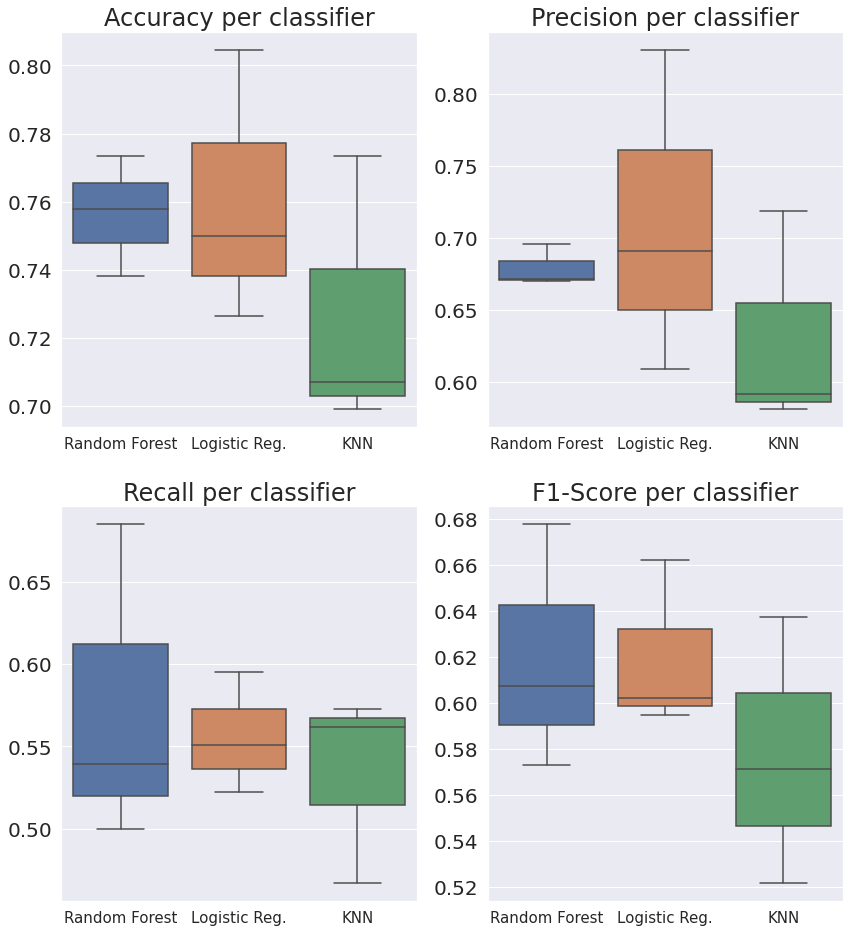

In [ ]:
# Using the original dataset and K = 3
df = pd.read_csv('https://raw.githubusercontent.com/LeonardoHoltz/MachineLearningDiabetesPredict/main/diabetes.csv')

cv_final_score_rf, cv_final_score_lr, cv_final_score_knn = cross_validation_training(df, 3, pre_processing_option='normalization')
plot_results_all_classifiers(cv_final_score_rf, cv_final_score_lr, cv_final_score_knn)

### K = 5

In [ ]:
# Using the original dataset and K = 5
df = pd.read_csv('https://raw.githubusercontent.com/LeonardoHoltz/MachineLearningDiabetesPredict/main/diabetes.csv')

cv_final_score_rf, cv_final_score_lr, cv_final_score_knn = cross_validation_training(df, 5, pre_processing_option='normalization')
plot_results_all_classifiers(cv_final_score_rf, cv_final_score_lr, cv_final_score_knn)

### K = 10

In [ ]:
# Using the original dataset and K = 10
df = pd.read_csv('https://raw.githubusercontent.com/LeonardoHoltz/MachineLearningDiabetesPredict/main/diabetes.csv')

cv_final_score_rf, cv_final_score_lr, cv_final_score_knn = cross_validation_training(df, 10, pre_processing_option='normalization')
plot_results_all_classifiers(cv_final_score_rf, cv_final_score_lr, cv_final_score_knn)

# Estratégia 2
## Remover todas as instancias que tiverem ao menos um valor já inválido (resultam 392 linhas ainda) e treinar com o dataframe resultante.

### K = 3

Shape: (392, 9)
{'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 5}
{'criterion': 'gini', 'max_depth': 4, 'n_estimators': 8}
{'criterion': 'gini', 'max_depth': 5, 'n_estimators': 6}
{'C': 100}
{'C': 100}
{'C': 1.0}
{'n_neighbors': 5}
{'n_neighbors': 9}
{'n_neighbors': 9}
Scores for Random Forests:
======= SCORE =======
Accuracy Mean: 0.7729105500097866
Accuracy Std: 0.03111901419010788
Precision Mean: 0.7233211233211233
Precision Std: 0.13896471785802791
Recall Mean: 0.5852713178294574
Recall Std: 0.09697671320307598
F1 Score Mean: 0.6298113307401233
F1 Score Std: 0.028423368345559866
Scores for Logistic Regression:
======= SCORE =======
Accuracy Mean: 0.7678019181835976
Accuracy Std: 0.024165046787578078
Precision Mean: 0.6937350549976088
Precision Std: 0.07532534744049574
Recall Mean: 0.5539112050739957
Recall Std: 0.038444486813208875
F1 Score Mean: 0.6130416130416131
F1 Score Std: 0.03180973815858703
Scores for K Nearest Neighbors:
======= SCORE =======
Accuracy Mean: 0.788

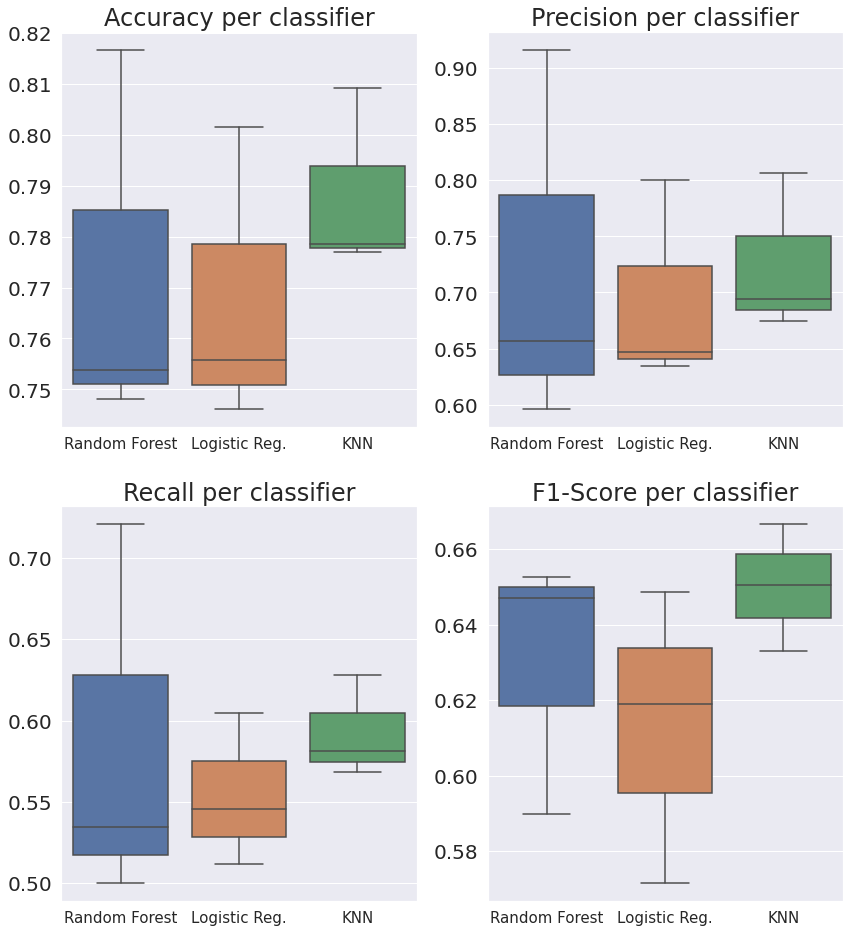

In [ ]:
# Using the dataset with only the valid data and K = 3
df = pd.read_csv('https://raw.githubusercontent.com/LeonardoHoltz/MachineLearningDiabetesPredict/main/diabetes.csv')
df_all_valid = df.loc[(df['BMI'] != 0) & (df['Insulin'] != 0) & (df['BloodPressure'] != 0) & (df['Glucose'] != 0) & (df['SkinThickness'] != 0)]

print(f'Shape: {df_all_valid.shape}') # (392, 9)

cv_final_score_rf, cv_final_score_lr, cv_final_score_knn = cross_validation_training(df_all_valid, 3, pre_processing_option='normalization')
plot_results_all_classifiers(cv_final_score_rf, cv_final_score_lr, cv_final_score_knn)

### K = 5

In [ ]:
# Using the dataset with only the valid data and K = 5
cv_final_score_rf, cv_final_score_lr, cv_final_score_knn = cross_validation_training(df_all_valid, 5, pre_processing_option='normalization')
plot_results_all_classifiers(cv_final_score_rf, cv_final_score_lr, cv_final_score_knn)

### K = 10 

In [ ]:
# Using the dataset with only the valid data and K = 10
cv_final_score_rf, cv_final_score_lr, cv_final_score_knn = cross_validation_training(df_all_valid, 10, pre_processing_option='normalization')
plot_results_all_classifiers(cv_final_score_rf, cv_final_score_lr, cv_final_score_knn)

# Estratégia 3

## Adicionar a estratégia anterior a remoção da coluna  *SkinThickness* e treinar com o dataframe resultante.

### K = 3

{'criterion': 'gini', 'max_depth': 3, 'n_estimators': 8}
{'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 9}
{'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 5}
{'C': 100}
{'C': 10}
{'C': 10}
{'n_neighbors': 3}
{'n_neighbors': 9}
{'n_neighbors': 7}
Scores for Random Forests:
======= SCORE =======
Accuracy Mean: 0.7856331963202191
Accuracy Std: 0.03356743115764172
Precision Mean: 0.7121443089430896
Precision Std: 0.09359047116143948
Recall Mean: 0.6153981677237491
Recall Std: 0.009575530825723195
F1 Score Mean: 0.6574770258980785
F1 Score Std: 0.03875042988574474
Scores for Logistic Regression:
======= SCORE =======
Accuracy Mean: 0.7677627715795654
Accuracy Std: 0.028976751557372674
Precision Mean: 0.6925925925925926
Precision Std: 0.07926272058901
Recall Mean: 0.5539112050739957
Recall Std: 0.038444486813208875
F1 Score Mean: 0.6132523384761729
F1 Score Std: 0.04024117911739997
Scores for K Nearest Neighbors:
======= SCORE =======
Accuracy Mean: 0.7652769622235271
Accu

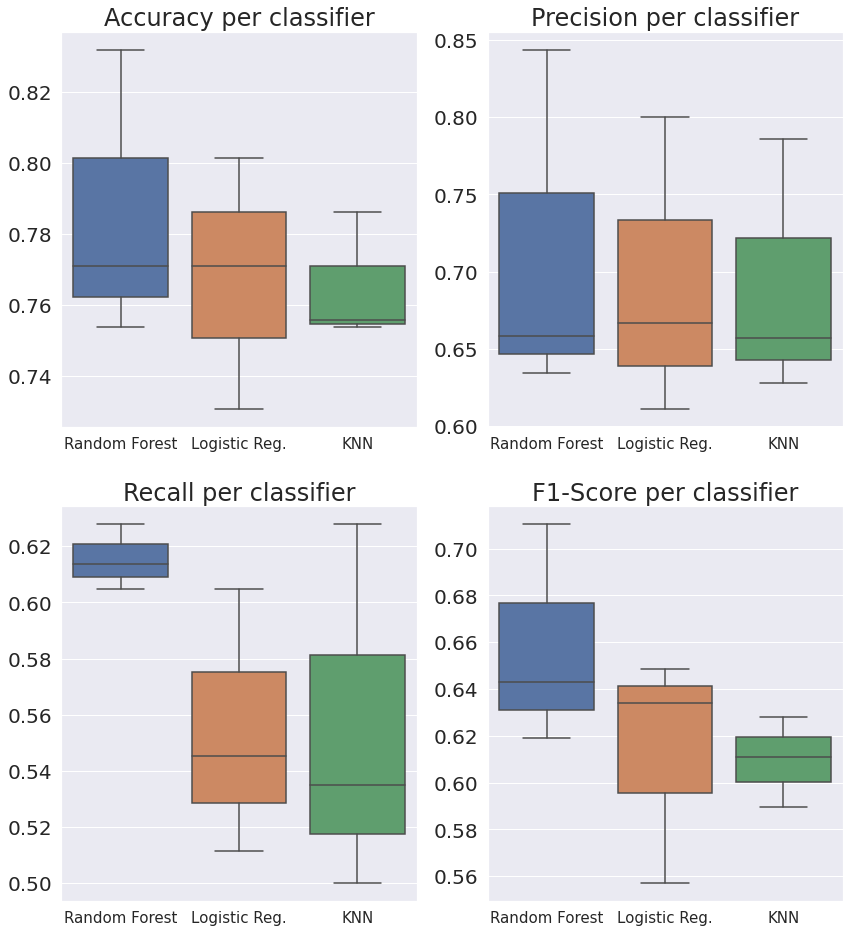

In [ ]:
# Using the dataset with only the valid data and without the SkinThickness column and K = 3
df_all_valid_no_st = df_all_valid.drop(['SkinThickness'], axis=1)
cv_final_score_rf, cv_final_score_lr, cv_final_score_knn = cross_validation_training(df_all_valid_no_st, 3, pre_processing_option='normalization')
plot_results_all_classifiers(cv_final_score_rf, cv_final_score_lr, cv_final_score_knn)

### K = 5

In [ ]:
# Using the dataset with only the valid data and without the SkinThickness column and K = 5
cv_final_score_rf, cv_final_score_lr, cv_final_score_knn = cross_validation_training(df_all_valid_no_st, 5, pre_processing_option='normalization')
plot_results_all_classifiers(cv_final_score_rf, cv_final_score_lr, cv_final_score_knn)

### K = 10

In [ ]:
# Using the dataset with only the valid data and without the SkinThickness column and K = 10
cv_final_score_rf, cv_final_score_lr, cv_final_score_knn = cross_validation_training(df_all_valid_no_st, 10, pre_processing_option='normalization')
plot_results_all_classifiers(cv_final_score_rf, cv_final_score_lr, cv_final_score_knn)

# Estratégia 4
## Remover instancias com muitos valores em 0, invalidar outliers e imputar os valores inválidos durante o treinamento.

### K = 3

{'criterion': 'gini', 'max_depth': 7, 'n_estimators': 4}
{'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 9}
{'criterion': 'gini', 'max_depth': 7, 'n_estimators': 9}
{'C': 100}
{'C': 100}
{'C': 100}
{'n_neighbors': 3}
{'n_neighbors': 7}
{'n_neighbors': 3}
Scores for Random Forests:
======= SCORE =======
Accuracy Mean: 0.7395833333333334
Accuracy Std: 0.010252614419286212
Precision Mean: 0.6621635069910932
Precision Std: 0.03894522800157184
Recall Mean: 0.5299625468164794
Recall Std: 0.05472524043521521
F1 Score Mean: 0.5855701224771434
F1 Score Std: 0.024077906645912955
Scores for Logistic Regression:
======= SCORE =======
Accuracy Mean: 0.7526041666666666
Accuracy Std: 0.03097754493065187
Precision Mean: 0.6930907205573243
Precision Std: 0.07711028931019209
Recall Mean: 0.5483978360382854
Recall Std: 0.046216022650576706
F1 Score Mean: 0.6077972422804185
F1 Score Std: 0.03273403162180297
Scores for K Nearest Neighbors:
======= SCORE =======
Accuracy Mean: 0.7356770833333334
Ac

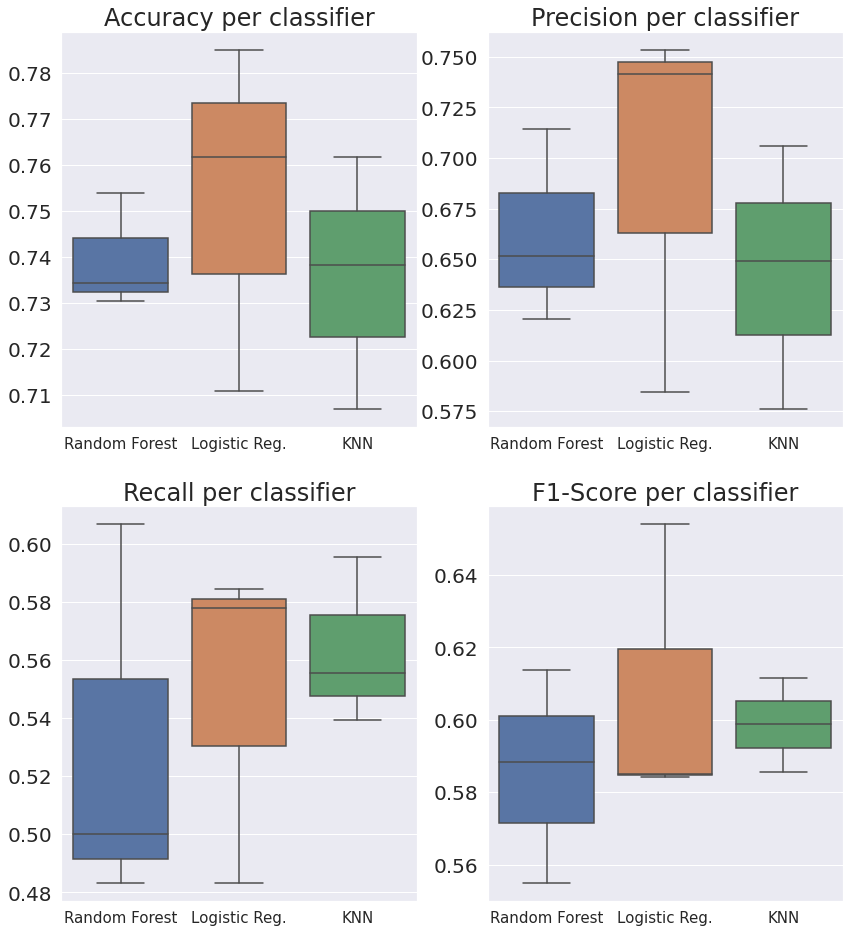

In [ ]:
# During the cross validation, we remove instances with a certain number of
# attributes with value 0, we invalidate the outliers and we imput the invalid values.
# K = 3
df = pd.read_csv('https://raw.githubusercontent.com/LeonardoHoltz/MachineLearningDiabetesPredict/main/diabetes.csv')

cv_final_score_rf, cv_final_score_lr, cv_final_score_knn = cross_validation_training(df, 3, pre_processing_option='imputer')
plot_results_all_classifiers(cv_final_score_rf, cv_final_score_lr, cv_final_score_knn)

### K = 5

In [ ]:
# During the cross validation, we remove instances with a certain number of
# attributes with value 0, we invalidate the outliers and we imput the invalid values.
# K = 5
df = pd.read_csv('https://raw.githubusercontent.com/LeonardoHoltz/MachineLearningDiabetesPredict/main/diabetes.csv')

cv_final_score_rf, cv_final_score_lr, cv_final_score_knn = cross_validation_training(df, 5, pre_processing_option='imputer')
plot_results_all_classifiers(cv_final_score_rf, cv_final_score_lr, cv_final_score_knn)

### K = 10

In [ ]:
# During the cross validation, we remove instances with a certain number of
# attributes with value 0, we invalidate the outliers and we imput the invalid values.
# K = 10
df = pd.read_csv('https://raw.githubusercontent.com/LeonardoHoltz/MachineLearningDiabetesPredict/main/diabetes.csv')

cv_final_score_rf, cv_final_score_lr, cv_final_score_knn = cross_validation_training(df, 10, pre_processing_option='imputer')
plot_results_all_classifiers(cv_final_score_rf, cv_final_score_lr, cv_final_score_knn)

# Análise de Redução de Dimensionalidade
Nosso dataset possui 8 atributos e destacamos já na nossa análise correlações interessantes sobre os dados. Vamos fazer agora uma análise de componentes principais e treinar um modelo com estes componentes.

Iremos fazer análise novamente sobre os dados válidos do problema.

O PC1 explica 88% da variancia dos dados, já o PC2 explica somente 6%. A partir do PC3, temos somente 2.5% da variancia. Por conta disso, optamos por deixar somente

In [ ]:
from sklearn.decomposition import PCA

df = pd.read_csv('https://raw.githubusercontent.com/LeonardoHoltz/MachineLearningDiabetesPredict/main/diabetes.csv')

df_all_valid = df.loc[(df['BMI'] != 0) & (df['Insulin'] != 0) & (df['BloodPressure'] != 0) & (df['Glucose'] != 0) & (df['SkinThickness'] != 0)]
df_all_valid = df_all_valid.reset_index(drop=True)

X = df_all_valid.drop(['Outcome'], axis=1)
y = df_all_valid['Outcome']

unique_classes, class_counts = np.unique(y, return_counts=True)
total = np.sum(class_counts)
print(f"Proportion:\n{unique_classes[0]} - {class_counts[0]/total}")
print(f"{unique_classes[1]} - {class_counts[1]/total}")

scaler = MinMaxScaler()
scaler.fit(X)
X[X.columns] = scaler.transform(X)

pca = PCA(n_components=3) # we use 5 just to see the variance ratio
pca.fit(X)
df_pca = pca.transform(X)

print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_))
print(pca.singular_values_)
df_pca = pd.DataFrame(data=df_pca)
df_pca['Outcome'] = y

Proportion:
0 - 0.6683673469387755
1 - 0.33163265306122447
[0.34857425 0.2000689  0.16354574]
0.7121888993289325
[5.61285665 4.25232148 3.84464213]


{'criterion': 'gini', 'max_depth': 6, 'n_estimators': 8}
{'criterion': 'gini', 'max_depth': 3, 'n_estimators': 9}
{'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 5}
{'learning_rate': 2, 'n_estimators': 30}
{'learning_rate': 2, 'n_estimators': 50}
{'learning_rate': 2, 'n_estimators': 150}
{'n_neighbors': 7}
{'n_neighbors': 5}
{'n_neighbors': 7}
Scores for Random Forests:
======= SCORE =======
Accuracy Mean: 0.7448228616167548
Accuracy Std: 0.040105490449202495
Precision Mean: 0.6747685185185185
Precision Std: 0.14244107209370613
Recall Mean: 0.5389358703312191
Recall Std: 0.11317229374932948
F1 Score Mean: 0.5809568088403747
F1 Score Std: 0.05253237592430452
Scores for Logistic Regression:
======= SCORE =======
Accuracy Mean: 0.7729301233118027
Accuracy Std: 0.032188186556892
Precision Mean: 0.6533018867924528
Precision Std: 0.07030781294123073
Recall Mean: 0.7001409443269907
Recall Std: 0.01606239791408242
F1 Score Mean: 0.6731532356532356
F1 Score Std: 0.029603181842560243
Sc

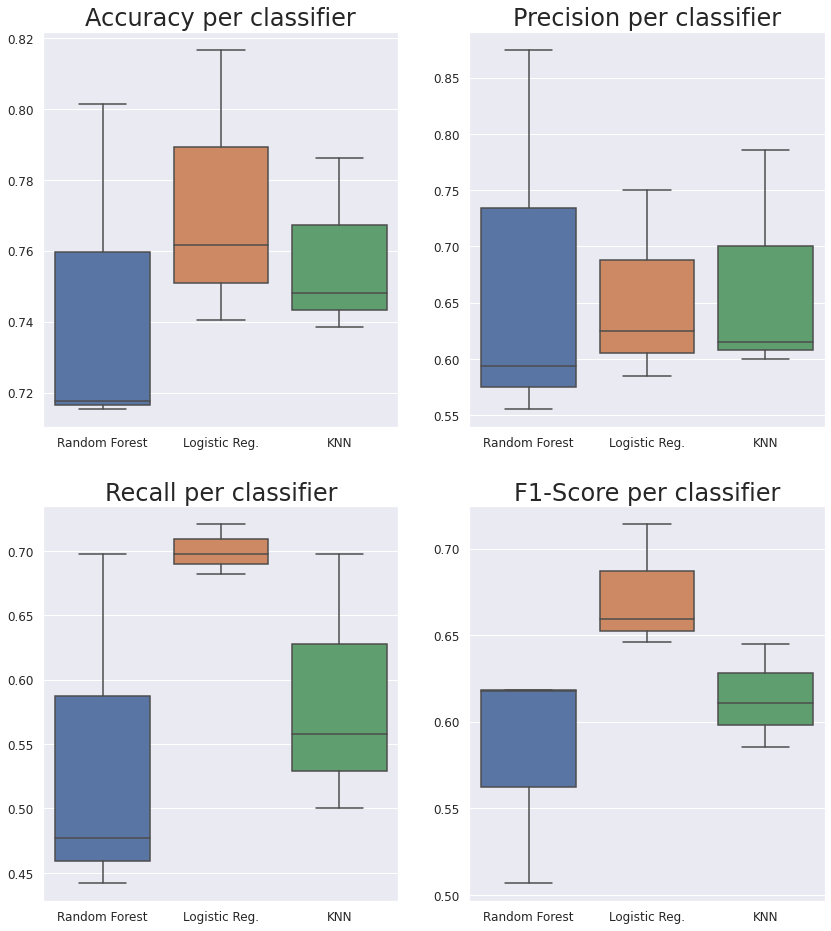

In [ ]:
cv_final_score_rf, cv_final_score_lr, cv_final_score_knn = cross_validation_training(df_pca, 3, pre_processing_option=None)
plot_results_all_classifiers(cv_final_score_rf, cv_final_score_lr, cv_final_score_knn)

# Referencias
Smith JW, Everhart JE, Dickson WC, Knowler WC, Johannes RS. Using the ADAP Learning Algorithm to Forecast the Onset of Diabetes Mellitus. Proc Annu Symp Comput Appl Med Care. 1988 Nov 9:261–5. PMCID: PMC2245318.

